# Hw2  - Part 1 

|Name     |Campus Email| ID  |
|---------|--------------------------------|----------|
|Oren Elmakis| oren.elmakis@campus.technion.ac.il|311265516|
|Alon spinner| alonspinner@campus.technion.ac.il| 305184335|

#Imports

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import nn

import torchvision as tv
from torchvision import transforms

import cv2
import os
import time
from torch.utils.cpp_extension import CUDA_HOME

#View 5 pictures from train set with ground truth
code architecture from tut_02_03

In [2]:
SVHN_dataset_train_untouched = tv.datasets.SVHN(
    root='./datasets',
    split='train',
    transform=transforms.ToTensor(),
    download=True)

In [3]:
#learn about iterators
list = iter([1,2,3])
print("list object:")
print(list)
print("list.next()")
print(list.__next__())
print(list.__next__()) #each use of __next__() brings up the next value in the list

list object:
list.next()
1
2


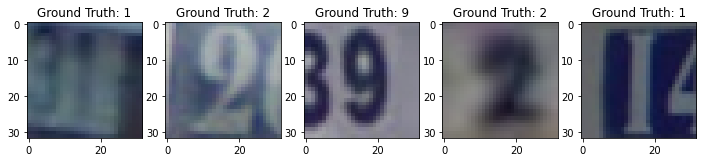

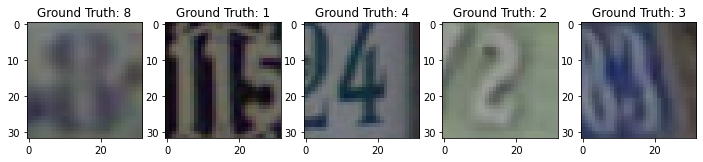

In [4]:
def convert_to_imshow_format(image):
    image = image.numpy()
    return image.transpose(1,2,0)

SVHN_loader_train_untouched = torch.utils.data.DataLoader(SVHN_dataset_train_untouched,
                                                          batch_size = 5,
                                                          shuffle=True)
dataiter = iter(SVHN_loader_train_untouched)
images, labels = dataiter.__next__() #takes first batch from loader! we defined 5

fig,axes = plt.subplots(1,len(images),figsize = (12,2.5))
for idx,image in enumerate(images):
    image_np=image.numpy()
    axes[idx].imshow(image_np.transpose(1,2,0))
    axes[idx].set_title("Ground Truth: {}".format(labels[idx]))

images, labels = dataiter.__next__() #takes second batch from loader!
fig,axes = plt.subplots(1,len(images),figsize = (12,2.5))
for idx,image in enumerate(images):
    image_np=image.numpy()
    axes[idx].imshow(image_np.transpose(1,2,0))
    axes[idx].set_title("Ground Truth: {}".format(labels[idx]))

#Build neural networks.
code architecutre from tut_02_03





##ALexNet_Modified:
Based on AlexNet, but modified for smaller images and  includes BatchNorm, drop out and more.
This is the base architecture with which we 'playing around'

In [0]:
class AlexNet_Modified(nn.Module):
#https://sushscience.wordpress.com/2016/12/04/understanding-alexnet/
#https://engmrk.com/alexnet-implementation-using-keras/
    def __init__(self):
        super().__init__()
        
        # Conv Layer block 1
        self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=96,kernel_size=3,padding=1), #kernel_size of 3 instead of 11 because images are 32x32 instead of 256x256
        nn.BatchNorm2d(96),
        nn.ReLU(inplace = True),
        nn.Conv2d(in_channels=96,out_channels=256,kernel_size=3,padding=1), #kernel_size of 3 instead of 5 because images are 32x32 instead of 256x256
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2), #stride 2 instead of 4. OUT: 16x16x256
        
        #Conv Layer block 2
        nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size=2,stride=2), #OUT: 8x8x384
        nn.Dropout2d(p=0.05), #added small dropout
            
        #Conv Layer block 3
        nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,padding=1), 
        nn.BatchNorm2d(384),
        nn.ReLU(inplace = True),
        nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1), #reduce channels
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2), #OUT: 4x4x256
        )

        self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(4096,1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024,512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512,10)
        )
        
    def forward(self,x):
        
        x = self.conv_layer(x)
        x = x.view(x.size(0),-1)
        x = self.fc_layer(x)
        return x

##ALexNet_Modified_NoBatchNorm:
just took out the batchnorms

In [0]:
class AlexNet_Modified_NoBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Conv Layer block 1
        self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=96,kernel_size=3,padding=1), #kernel_size of 3 instead of 11 because images are 32x32 instead of 256x256
        nn.ReLU(inplace = True),
        nn.Conv2d(in_channels=96,out_channels=256,kernel_size=3,padding=1), #kernel_size of 3 instead of 5 because images are 32x32 instead of 256x256
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2), #stride 2 instead of 4. OUT: 16x16x256
        
        #Conv Layer block 2
        nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,padding=1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size=2,stride=2), #OUT: 8x8x384
        nn.Dropout2d(p=0.05), #added small dropout
            
        #Conv Layer block 3
        nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,padding=1), 
        nn.ReLU(inplace = True),
        nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1), #reduce channels
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2), #OUT: 4x4x256
        )

        self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(4096,1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024,512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512,10)
        )
        
    def forward(self,x):
        
        x = self.conv_layer(x)
        x = x.view(x.size(0),-1)
        x = self.fc_layer(x)
        return x

## AlexNet_Modified_Smaller
Removed the second conv block

In [0]:
class AlexNet_Modified_Smaller(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Conv Layer block 1
        self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=96,kernel_size=3,padding=1), #kernel_size of 3 instead of 11 because images are 32x32 instead of 256x256
        nn.BatchNorm2d(96),
        nn.ReLU(inplace = True),
        nn.Conv2d(in_channels=96,out_channels=256,kernel_size=3,padding=1), #kernel_size of 3 instead of 5 because images are 32x32 instead of 256x256
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2), #stride 2 instead of 4. OUT: 16x16x256
            
        #Conv Layer block 3
        nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,padding=1), 
        nn.BatchNorm2d(384),
        nn.ReLU(inplace = True),
        nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1), #reduce channels
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=4,stride=4), #OUT: 4x4x256
        )

        self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(4096,1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024,512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512,10)
        )
        
    def forward(self,x):
        
        x = self.conv_layer(x)
        x = x.view(x.size(0),-1)
        x = self.fc_layer(x)
        return x

## Mostly_FC
#1 conv layer block which outputs 3 channels only. then into an fc layer

In [0]:
class Mostly_FC(nn.Module):
    def __init__(self):
        super().__init__()

        # Conv Layer block 1
        self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=96,kernel_size=3,padding=1), 
        nn.BatchNorm2d(96),
        nn.ReLU(inplace = True),
        nn.Conv2d(in_channels=96,out_channels=3,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2), #stride 2 instead of 4. OUT: 16x16x3
        )

        self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(768,768),
        nn.ReLU(inplace=True),
        nn.Linear(768,768),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(768,10)
        )
        
    def forward(self,x):
        
        x = self.conv_layer(x)
        x = x.view(x.size(0),-1)
        x = self.fc_layer(x)
        return x

#Train models and check accuracy

##Defining loaders, parameters and functions

In [9]:
#define train set
transform_train=transforms.Compose([transforms.RandomCrop(32,padding = 4),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
SVHN_trainset = tv.datasets.SVHN(root='./datasets',
                                 split='train',
                                 transform=transform_train,
                                 download=True)

#define test set
transform_test=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
SVHN_testset = tv.datasets.SVHN(root='./datasets',
                                 split='train',
                                 transform=transform_test,
                                 download=True)

Using downloaded and verified file: ./datasets/train_32x32.mat
Using downloaded and verified file: ./datasets/train_32x32.mat


In [0]:
#hyper parameters
batch_size = 128
learning_rate = 1e-4
epochs = 10

#loaders
SVHN_trainloader = torch.utils.data.DataLoader(SVHN_trainset,batch_size=batch_size,shuffle = True,
                                         num_workers = 2)
SVHN_testloader = torch.utils.data.DataLoader(SVHN_testset,batch_size=batch_size,shuffle = True,
                                         num_workers = 2)

#CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#cost/loss function
criterion = nn.CrossEntropyLoss() 

#optimizer moved into train_and_check

In [0]:
def calculate_accuracy(model,dataloader,device):
    model.eval()
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([10,10],int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(),predicted[i].item()] += 1
                
    model_accuracy = total_correct/total_images *100
    return model_accuracy, confusion_matrix

In [0]:
def train_and_check(model,trainloader,testloader,learning_rate,epochs,SaveLocation):
  optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
  LossArray=np.zeros(epochs)
  for epoch in range(1 , epochs+1):
      model.train()
      running_loss = 0.0
      epoch_time = time.time()
      for i,data in enumerate(trainloader,0):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          
          outputs = model(inputs)
          loss = criterion(outputs,labels)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          running_loss += loss.data.item()
          
      
      running_loss /= len(trainloader)
      LossArray[epoch-1]=running_loss
      
      train_accuracy, _ = calculate_accuracy(model,trainloader,device)
      test_accuracy,_ = calculate_accuracy(model,testloader,device)
      
      log = "Epoch: {}| Loss:{:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% |".format(epoch,running_loss,train_accuracy,test_accuracy)
      epoch_time = time.time() - epoch_time
      log += "Epoch Time: {:.2f} secs".format(epoch_time)
      print(log)
      
      if epoch %epochs == 0:
          print('==saving model ...')
          state = {'net': model.state_dict(),'epoch': epoch}
          if not os.path.isdir('checkpoints'):
              os.mkdir('checkpoints')
          torch.save(state,SaveLocation)
  print('==> Finished Training')
  return LossArray

In [0]:
def plot_confusion_matrix(model,testloader,device,classes):
  test_accuracy, confusion_matrix = calculate_accuracy(model, testloader, device)
  print("test accuracy: {:.3f}%".format(test_accuracy))

  # plot confusion matrix
  fig, ax = plt.subplots(1,1,figsize=(8,6))
  ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
  plt.ylabel('Actual Category')
  plt.yticks(range(10), classes)
  plt.xlabel('Predicted Category')
  plt.xticks(range(10), classes)
  plt.show()

In [0]:
def plot_loss(Loss):
  fig,axes = plt.subplots(1,2,figsize = (12,2.5))
  
  axes[0].plot(Loss)
  axes[0].set_title("Loss vs epoch")
  axes[0].set_xlabel("epoch")
  axes[0].set_ylabel("Loss")

  axes[1].plot(np.diff(Loss))
  axes[1].set_title("diff(Loss) vs epoch")
  axes[1].set_xlabel("epoch")
  axes[1].set_ylabel("diff(Loss)")

## Check Results

### AlexNet_Modified

Epoch: 1| Loss:1.2761 | Training accuracy: 79.531% | Test accuracy: 79.909% |Epoch Time: 85.72 secs
Epoch: 2| Loss:0.5192 | Training accuracy: 86.612% | Test accuracy: 86.829% |Epoch Time: 86.00 secs
Epoch: 3| Loss:0.3948 | Training accuracy: 89.105% | Test accuracy: 90.095% |Epoch Time: 86.25 secs
Epoch: 4| Loss:0.3411 | Training accuracy: 90.628% | Test accuracy: 91.381% |Epoch Time: 86.20 secs
Epoch: 5| Loss:0.3059 | Training accuracy: 91.692% | Test accuracy: 92.141% |Epoch Time: 86.11 secs
Epoch: 6| Loss:0.2819 | Training accuracy: 92.559% | Test accuracy: 92.814% |Epoch Time: 85.91 secs
Epoch: 7| Loss:0.2616 | Training accuracy: 93.184% | Test accuracy: 93.560% |Epoch Time: 86.71 secs
Epoch: 8| Loss:0.2469 | Training accuracy: 93.490% | Test accuracy: 93.445% |Epoch Time: 86.66 secs
Epoch: 9| Loss:0.2326 | Training accuracy: 93.977% | Test accuracy: 94.244% |Epoch Time: 86.76 secs
Epoch: 10| Loss:0.2208 | Training accuracy: 94.237% | Test accuracy: 94.574% |Epoch Time: 87.08 secs

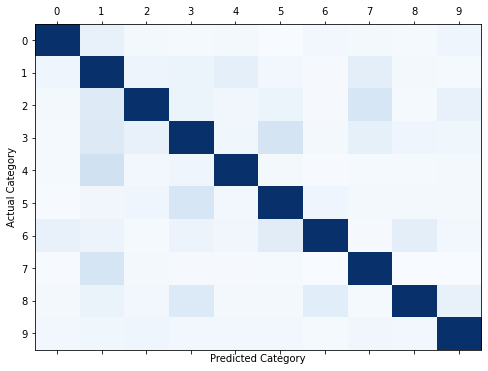

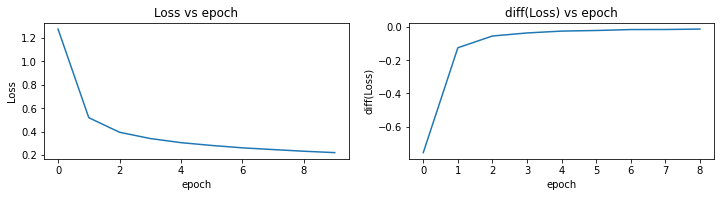

In [15]:
#train
model=AlexNet_Modified().to(device)
SaveLocation='./checkpoints/AlexNet_Modified'
Loss=train_and_check(model,SVHN_trainloader,SVHN_testloader,learning_rate,epochs,SaveLocation)

#plot confusion matrix
state = torch.load(SaveLocation, map_location=device)
model.load_state_dict(state['net'])
plot_confusion_matrix(model,SVHN_testloader,device,classes=range(10))

#plot loss in trainning
plot_loss(Loss)

### AlexNet_Modified_NoBatchNorm

Epoch: 1| Loss:2.1426 | Training accuracy: 42.668% | Test accuracy: 46.651% |Epoch Time: 84.90 secs
Epoch: 2| Loss:1.2006 | Training accuracy: 70.994% | Test accuracy: 73.373% |Epoch Time: 85.10 secs
Epoch: 3| Loss:0.6930 | Training accuracy: 82.525% | Test accuracy: 83.663% |Epoch Time: 84.96 secs
Epoch: 4| Loss:0.5127 | Training accuracy: 85.623% | Test accuracy: 86.605% |Epoch Time: 85.00 secs
Epoch: 5| Loss:0.4253 | Training accuracy: 88.635% | Test accuracy: 88.559% |Epoch Time: 85.05 secs
Epoch: 6| Loss:0.3752 | Training accuracy: 89.583% | Test accuracy: 90.076% |Epoch Time: 85.41 secs
Epoch: 7| Loss:0.3432 | Training accuracy: 90.704% | Test accuracy: 90.832% |Epoch Time: 85.07 secs
Epoch: 8| Loss:0.3133 | Training accuracy: 91.769% | Test accuracy: 91.993% |Epoch Time: 84.89 secs
Epoch: 9| Loss:0.2916 | Training accuracy: 91.847% | Test accuracy: 92.425% |Epoch Time: 85.42 secs
Epoch: 10| Loss:0.2776 | Training accuracy: 92.409% | Test accuracy: 92.354% |Epoch Time: 85.10 secs

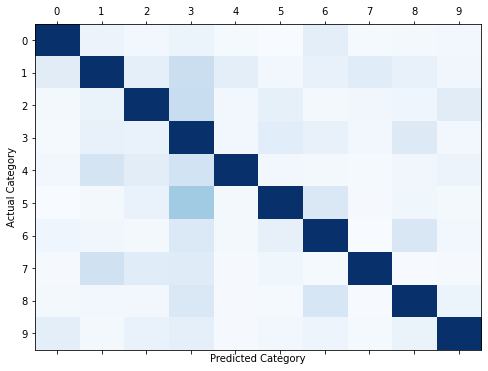

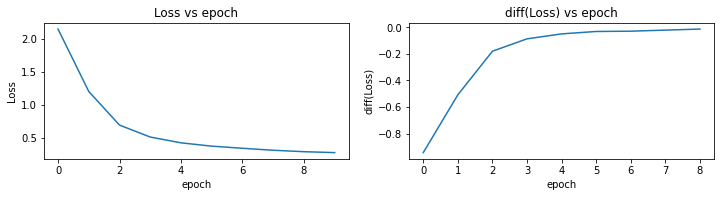

In [16]:
#train
model=AlexNet_Modified_NoBatchNorm().to(device)
SaveLocation='./checkpoints/AlexNet_Modified_NoBatchNorm'
Loss=train_and_check(model,SVHN_trainloader,SVHN_testloader,learning_rate,epochs,SaveLocation)

#plot confusion matrix
state = torch.load(SaveLocation, map_location=device)
model.load_state_dict(state['net'])
plot_confusion_matrix(model,SVHN_testloader,device,classes=range(10))

#plot loss in trainning
plot_loss(Loss)

### AlexNet_Modified_Smaller

Epoch: 1| Loss:1.3654 | Training accuracy: 74.953% | Test accuracy: 78.934% |Epoch Time: 80.04 secs
Epoch: 2| Loss:0.6566 | Training accuracy: 83.636% | Test accuracy: 86.083% |Epoch Time: 80.28 secs
Epoch: 3| Loss:0.4905 | Training accuracy: 87.315% | Test accuracy: 88.854% |Epoch Time: 80.05 secs
Epoch: 4| Loss:0.4096 | Training accuracy: 88.677% | Test accuracy: 90.649% |Epoch Time: 80.01 secs
Epoch: 5| Loss:0.3699 | Training accuracy: 90.114% | Test accuracy: 91.277% |Epoch Time: 79.95 secs
Epoch: 6| Loss:0.3351 | Training accuracy: 90.327% | Test accuracy: 91.513% |Epoch Time: 80.06 secs
Epoch: 7| Loss:0.3110 | Training accuracy: 91.257% | Test accuracy: 93.020% |Epoch Time: 79.73 secs
Epoch: 8| Loss:0.2936 | Training accuracy: 91.882% | Test accuracy: 93.127% |Epoch Time: 79.51 secs
Epoch: 9| Loss:0.2732 | Training accuracy: 92.674% | Test accuracy: 93.730% |Epoch Time: 80.00 secs
Epoch: 10| Loss:0.2629 | Training accuracy: 92.805% | Test accuracy: 93.850% |Epoch Time: 80.33 secs

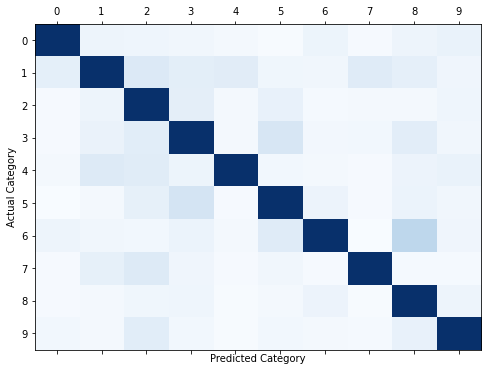

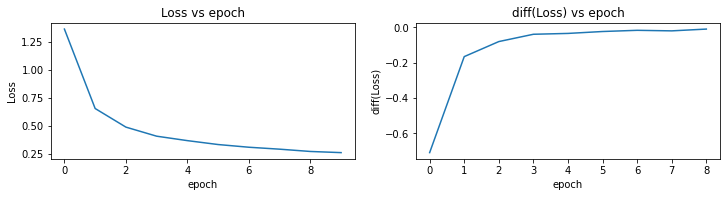

In [17]:
#train
model=AlexNet_Modified_Smaller().to(device)
SaveLocation='./checkpoints/AlexNet_Modified_Smaller'
Loss=train_and_check(model,SVHN_trainloader,SVHN_testloader,learning_rate,epochs,SaveLocation)

#plot confusion matrix
state = torch.load(SaveLocation, map_location=device)
model.load_state_dict(state['net'])
plot_confusion_matrix(model,SVHN_testloader,device,classes=range(10))

#plot loss in trainning
plot_loss(Loss)

###Mostly_FC

Epoch: 1| Loss:1.9717 | Training accuracy: 44.525% | Test accuracy: 52.091% |Epoch Time: 65.50 secs
Epoch: 2| Loss:1.5100 | Training accuracy: 55.223% | Test accuracy: 62.283% |Epoch Time: 65.10 secs
Epoch: 3| Loss:1.3105 | Training accuracy: 61.742% | Test accuracy: 67.671% |Epoch Time: 65.16 secs
Epoch: 4| Loss:1.1898 | Training accuracy: 64.263% | Test accuracy: 70.389% |Epoch Time: 66.04 secs
Epoch: 5| Loss:1.0973 | Training accuracy: 67.503% | Test accuracy: 72.882% |Epoch Time: 66.00 secs
Epoch: 6| Loss:1.0392 | Training accuracy: 69.693% | Test accuracy: 74.630% |Epoch Time: 64.90 secs
Epoch: 7| Loss:0.9807 | Training accuracy: 71.403% | Test accuracy: 75.604% |Epoch Time: 64.63 secs
Epoch: 8| Loss:0.9295 | Training accuracy: 72.965% | Test accuracy: 77.235% |Epoch Time: 65.14 secs
Epoch: 9| Loss:0.8904 | Training accuracy: 74.366% | Test accuracy: 78.043% |Epoch Time: 65.82 secs
Epoch: 10| Loss:0.8542 | Training accuracy: 75.125% | Test accuracy: 79.143% |Epoch Time: 65.86 secs

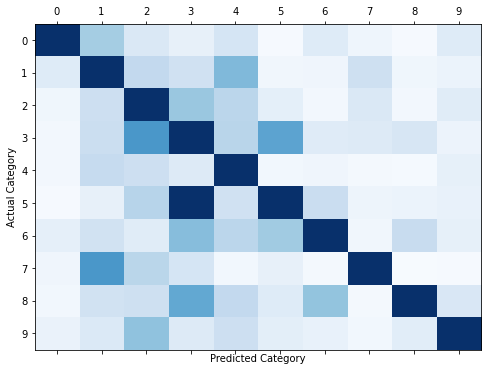

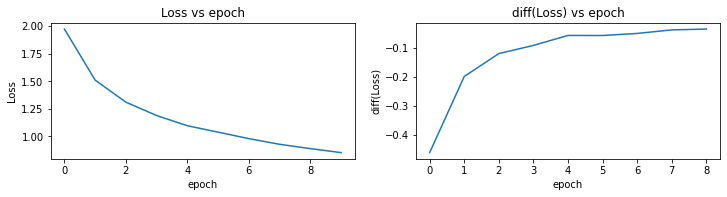

In [18]:
#train
model=Mostly_FC().to(device)
SaveLocation='./checkpoints/Mostly_FC'
Loss=train_and_check(model,SVHN_trainloader,SVHN_testloader,learning_rate,epochs,SaveLocation)

#plot confusion matrix
state = torch.load(SaveLocation, map_location=device)
model.load_state_dict(state['net'])
plot_confusion_matrix(model,SVHN_testloader,device,classes=range(10))

#plot loss in trainning
plot_loss(Loss)

#Jugle with AlexNet Modified

## Jugle1

Epoch: 1| Loss:1.7270 | Training accuracy: 61.684% | Test accuracy: 65.434% |Epoch Time: 79.58 secs
Epoch: 2| Loss:0.8720 | Training accuracy: 77.290% | Test accuracy: 78.008% |Epoch Time: 79.36 secs
Epoch: 3| Loss:0.6161 | Training accuracy: 83.397% | Test accuracy: 84.354% |Epoch Time: 79.24 secs
Epoch: 4| Loss:0.4965 | Training accuracy: 85.839% | Test accuracy: 86.299% |Epoch Time: 79.39 secs
Epoch: 5| Loss:0.4289 | Training accuracy: 87.560% | Test accuracy: 88.372% |Epoch Time: 79.39 secs
==saving model ...
==> Finished Training
test accuracy: 88.372%


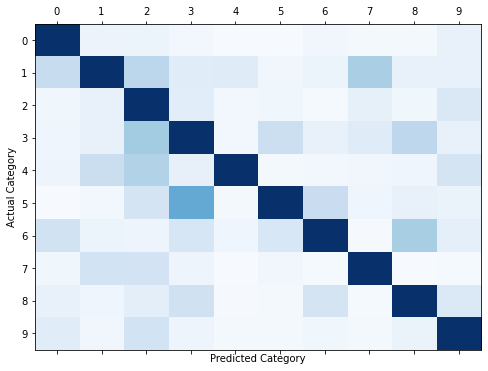

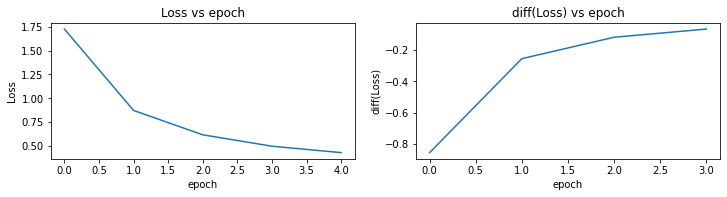

In [19]:
batch_size = 512
learning_rate = 1e-4
epochs = 5

#loaders
SVHN_trainloader = torch.utils.data.DataLoader(SVHN_trainset,batch_size=batch_size,shuffle = True,
                                         num_workers = 2)
SVHN_testloader = torch.utils.data.DataLoader(SVHN_testset,batch_size=batch_size,shuffle = True,
                                         num_workers = 2)

#train
model=AlexNet_Modified().to(device)
SaveLocation='./checkpoints/AlexNet_Modified_Jugle1'
Loss=train_and_check(model,SVHN_trainloader,SVHN_testloader,learning_rate,epochs,SaveLocation)

#plot confusion matrix
state = torch.load(SaveLocation, map_location=device)
model.load_state_dict(state['net'])
plot_confusion_matrix(model,SVHN_testloader,device,classes=range(10))

#plot loss in trainning
plot_loss(Loss)

##Jugle2

Epoch: 1| Loss:2.2839 | Training accuracy: 18.928% | Test accuracy: 19.018% |Epoch Time: 78.45 secs
Epoch: 2| Loss:1.9090 | Training accuracy: 44.520% | Test accuracy: 47.750% |Epoch Time: 78.94 secs
Epoch: 3| Loss:1.3761 | Training accuracy: 60.954% | Test accuracy: 61.798% |Epoch Time: 78.89 secs
Epoch: 4| Loss:1.0439 | Training accuracy: 70.898% | Test accuracy: 70.021% |Epoch Time: 78.41 secs
Epoch: 5| Loss:0.8758 | Training accuracy: 76.442% | Test accuracy: 76.375% |Epoch Time: 78.58 secs
==saving model ...
==> Finished Training
test accuracy: 76.375%


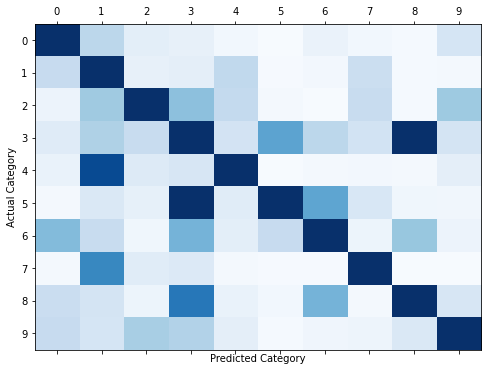

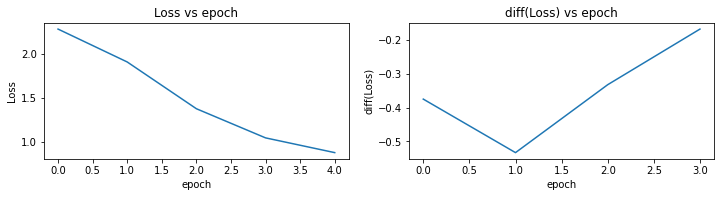

In [20]:
batch_size = 1024
learning_rate = 1e-3
epochs = 5

#loaders
SVHN_trainloader = torch.utils.data.DataLoader(SVHN_trainset,batch_size=batch_size,shuffle = True,
                                         num_workers = 2)
SVHN_testloader = torch.utils.data.DataLoader(SVHN_testset,batch_size=batch_size,shuffle = True,
                                         num_workers = 2)

#train
model=AlexNet_Modified().to(device)
SaveLocation='./checkpoints/AlexNet_Modified_Jugle2'
Loss=train_and_check(model,SVHN_trainloader,SVHN_testloader,learning_rate,epochs,SaveLocation)

#plot confusion matrix
state = torch.load(SaveLocation, map_location=device)
model.load_state_dict(state['net'])
plot_confusion_matrix(model,SVHN_testloader,device,classes=range(10))

#plot loss in trainning
plot_loss(Loss)

## Jugle3

Epoch: 1| Loss:2.1021 | Training accuracy: 37.312% | Test accuracy: 40.878% |Epoch Time: 79.03 secs
Epoch: 2| Loss:1.3999 | Training accuracy: 67.547% | Test accuracy: 69.223% |Epoch Time: 79.42 secs
Epoch: 3| Loss:0.7801 | Training accuracy: 80.914% | Test accuracy: 81.486% |Epoch Time: 79.41 secs
Epoch: 4| Loss:0.5589 | Training accuracy: 84.362% | Test accuracy: 84.997% |Epoch Time: 79.81 secs
Epoch: 5| Loss:0.4618 | Training accuracy: 87.332% | Test accuracy: 87.850% |Epoch Time: 79.65 secs
Epoch: 6| Loss:0.4035 | Training accuracy: 89.223% | Test accuracy: 89.652% |Epoch Time: 79.80 secs
Epoch: 7| Loss:0.3665 | Training accuracy: 90.065% | Test accuracy: 90.237% |Epoch Time: 79.61 secs
Epoch: 8| Loss:0.3377 | Training accuracy: 89.488% | Test accuracy: 89.351% |Epoch Time: 79.82 secs
Epoch: 9| Loss:0.3221 | Training accuracy: 91.803% | Test accuracy: 92.102% |Epoch Time: 79.66 secs
Epoch: 10| Loss:0.2950 | Training accuracy: 92.158% | Test accuracy: 92.272% |Epoch Time: 79.40 secs

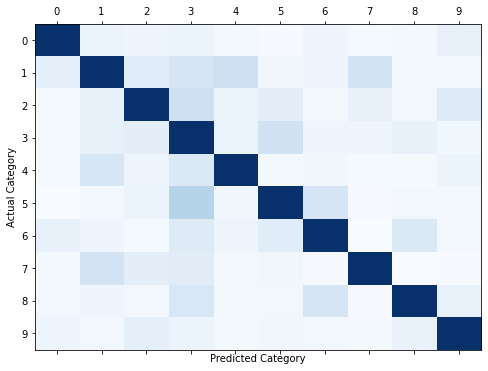

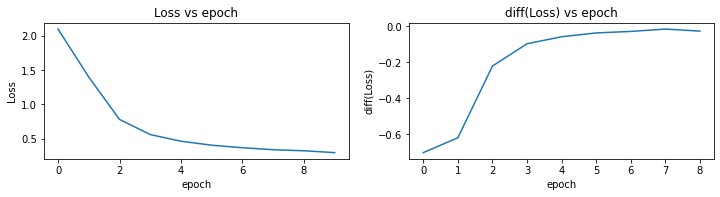

In [21]:
batch_size = 1024
learning_rate = 5*1e-4
epochs = 10

#loaders
SVHN_trainloader = torch.utils.data.DataLoader(SVHN_trainset,batch_size=batch_size,shuffle = True,
                                         num_workers = 2)
SVHN_testloader = torch.utils.data.DataLoader(SVHN_testset,batch_size=batch_size,shuffle = True,
                                         num_workers = 2)

#train
model=AlexNet_Modified().to(device)
SaveLocation='./checkpoints/AlexNet_Modified_Jugle3'
Loss=train_and_check(model,SVHN_trainloader,SVHN_testloader,learning_rate,epochs,SaveLocation)

#plot confusion matrix
state = torch.load(SaveLocation, map_location=device)
model.load_state_dict(state['net'])
plot_confusion_matrix(model,SVHN_testloader,device,classes=range(10))

#plot loss in trainning
plot_loss(Loss)